In [6]:
import os 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".80"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from pybird import config 
config.set_jax_enabled(True)
from train_pybird_emulators.emu_utils import emu_utils 
import numpy as np 
import matplotlib.pyplot as plt 
import h5py
from scipy.interpolate import interp1d
import jax 
import jax.numpy as jnp
import pybird

In [7]:
with h5py.File('/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/lhc_bank_z0p5to2p5/total_data.h5', 'r') as hdf_file:
    print(hdf_file.keys())
    print(hdf_file["params"][-9])    
    pk_test = hdf_file["pk_lin"][-9]

<KeysViewHDF5 ['params', 'pk_lin']>
[ 0.1566485   0.02405606  0.60950625  0.0387175   0.736829    2.62749
  0.41931    -1.0994935   0.57862   ]


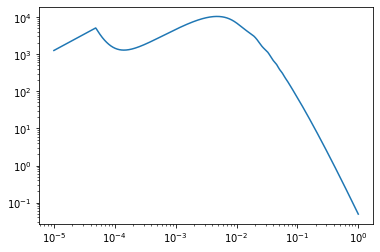

In [5]:
kk = np.logspace(-5,0, 1000)
plt.loglog(kk, pk_test)

In [ ]:
from pybird.correlator import Correlator

In [ ]:
N = Correlator()
#Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.6,
'fftaccboost': 2,
'with_resum': True, 'with_exact_time': True,
'with_time': False, # time unspecified
'km': 1., 'kr': 1., 'nd': 3e-4,
'eft_basis': 'eftoflss', 'with_stoch': True})

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True) 

In [ ]:
def get_logslope(x, f, side='left'):
    if side == 'left': 
        n = (np.log(f[1]) - np.log(f[0])) / (np.log(x[1]) - np.log(x[0]))
        A = f[0] / x[0]**n
    elif side == 'right':
        n = (np.log(f[-1]) - np.log(f[-2])) / (np.log(x[-1]) - np.log(x[-2]))
        A = f[-1] / x[-1]**n
    return A, n  

In [ ]:
from utils import PiecewiseSpline_jax

In [ ]:
# k_l, k_r =  1e-4, 1.0 #In Mpc/h
k_l, k_r =  1e-4, 0.7 #In Mpc/h

kk = np.logspace(-5, 1, 1000)

mask = (kk < k_l) | (kk > k_r)
kk_ = kk[~mask]
pk_max = np.max(pk_test)
pk = 1.*pk_test / pk_max # normalizing
ilogpk = interp1d(np.log(kk), np.log(pk), kind = 'cubic')
pkk_ = np.exp(ilogpk(np.log(kk_)))

knots_orig = np.load("/cluster/work/refregier/alexree/frequentist_framework/pybird_emu/data/emu/knots.npy")

knots_125 = np.load("/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/hpc_work/final_knots_125.npy")
nknots = 80
k_low = 0.02
k_mid = 0.1
n_low = 15
n_mid = 13
n_high = nknots - n_low - n_mid
knots_low = np.geomspace(k_l, k_low, n_low)
knots_mid = np.geomspace(k_low+0.001,k_mid, n_mid)
knots_high = np.geomspace(k_mid+0.01, k_r, n_high)
knots = np.concatenate((knots_low,knots_mid,knots_high))

# knots = knots_orig 

logpk = ilogpk(np.log(knots))
A_r, n_r = get_logslope(kk_, pkk_, side='right')
pk_r = A_r * k_r**n_r
dpk_r = A_r * n_r * k_r**(n_r-1.)
dlogpk_r = (k_r/pk_r * dpk_r)

In [ ]:
knots_mid

In [ ]:
knots_high

In [ ]:
plt.xscale("log")
plt.scatter(knots, y=np.zeros_like(knots))

In [ ]:
spline_1 = utils.PiecewiseSpline_jax(knots, logpk, dlogpk_r, boundaries=True)

In [ ]:
# plt.plot(test_kk, np.exp(spline_1(np.log(test_kk))))
# plt.plot(test_kk, np.exp(ilogpk(np.log(test_kk))), 'r--')
plt.xscale("log")
plt.plot(kk, np.exp(spline_1(np.log(kk))))
plt.plot(kk, np.exp(ilogpk(np.log(kk))), 'r--')

In [ ]:
plt.xscale("log")
plt.xlim(1e-4,1)
plt.ylim(0.9990,1.005)
plt.plot(kk, np.exp(spline_1(np.log(kk)))/np.exp(ilogpk(np.log(kk))))

In [ ]:
#now lets try with the Jax version of things 
import jax.numpy as jnp

from utils import PiecewiseSpline_jax
from utils import InterpolatedUnivariateSpline_jax

In [ ]:
kk_jax = jnp.array(kk)
pk_jax = jnp.array(pk)
knots_jax = jnp.array(knots)
ilogpk_jax =  InterpolatedUnivariateSpline_jax(jnp.log(kk_jax), jnp.log(pk_jax), endpoints='natural')
dlogpk_r_jax = dlogpk_r.astype(jnp.float64)
logpk_jax = ilogpk_jax(jnp.log(knots_jax))
spline_2 = PiecewiseSpline_jax(knots_jax, logpk_jax, dlogpk_r_jax)

In [ ]:
#The internal knots used by pybird up to kmax=0.4 which is where the emus are trained
k_arr = np.array([0.001 , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
    0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.035 , 0.04  , 0.045 ,
    0.05  , 0.055 , 0.06  , 0.065 , 0.07  , 0.075 , 0.08  , 0.085 ,
    0.09  , 0.095 , 0.1   , 0.105 , 0.11  , 0.115 , 0.12  , 0.125 ,
    0.13  , 0.135 , 0.14  , 0.145 , 0.15  , 0.155 , 0.16  , 0.165 ,
    0.17  , 0.175 , 0.18  , 0.185 , 0.19  , 0.195 , 0.2   , 0.205 ,
    0.21  , 0.215 , 0.22  , 0.225 , 0.23  , 0.235 , 0.24  , 0.245 ,
    0.25  , 0.255 , 0.26  , 0.265 , 0.27  , 0.275 , 0.28  , 0.285 ,
    0.29  , 0.295 , 0.3   , 0.31  , 0.32  , 0.33  , 0.34  , 0.35  ,
    0.36  , 0.37  , 0.38  , 0.39  , 0.4])

In [ ]:
    #Get covariance matrix at reference cosmology 
from classy import Class
import utils
z=0.5
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 30, 'z_max_pk': z})
M.compute()
D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z), 

pk_lin = np.array([M.pk_lin(k*M.h(),z)*M.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3
ipk_h = interp1d(kk, pk_lin, kind='cubic')

Vs = 1.e11      # ideal volume (in [Mpc/h]^3), > 3 x better than DESI / Euclid (BOSS ~ 3e9, DESI ~ 3e10)
nbar = 6e-3     # ideal nbar (for b1~2) (in [Mpc/h]^3), > 12 x better than DESI / Euclid

# Vs = 3.e10      # ideal volume (in [Mpc/h]^3), > 3 x better than DESI / Euclid (BOSS ~ 3e9, DESI ~ 3e10)
# nbar = 2e-3     # ideal nbar (for b1~2) (in [Mpc/h]^3), > 12 x better than DESI / Euclid

cov = utils.get_cov(k_arr, ipk_h, 1.9536, f1, mult=3, nbar=nbar, Vs=Vs)
cov_inv = jnp.linalg.inv(cov)
err = np.sqrt(np.diag(cov))

cov_desi = utils.get_cov(k_arr, ipk_h, 1.9536, f1, mult=3, nbar=nbar/3, Vs=Vs/3)

In [ ]:
f1

In [ ]:
from pybird import config
config.set_jax_enabled(True) # Enable JAX by setting the config Class
from pybird.correlator import Correlator

In [ ]:
N = Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
    'fftaccboost': 2,
    'with_time': False,
    'with_resum': False,
    'with_exact_time': True,
    'km': 1., 'kr': 1., 'nd': 3e-4,
    'eft_basis': 'eftoflss', 'with_stoch': True})

N_rec = Correlator()
N_rec.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
    'fftaccboost': 2,
    'with_time': False,
    'with_resum': False,
    'with_exact_time': True,
    'km': 1., 'kr': 1., 'nd': 3e-4,
    'eft_basis': 'eftoflss', 'with_stoch': True})

In [ ]:
def get_logslope_jax(x, f, side='left'):
    if side == 'left': 
        n = (jnp.log(f[1]) - jnp.log(f[0])) / (jnp.log(x[1]) - jnp.log(x[0]))
        A = f[0] / x[0]**n
    elif side == 'right':
        n = (jnp.log(f[-1]) - jnp.log(f[-2])) / (jnp.log(x[-1]) - jnp.log(x[-2]))
        A = f[-1] / x[-1]**n
    return A, n

In [ ]:
mask = jnp.where((kk > k_l) & (kk < k_r))
def get_pybird_chi2(knots, cov_inv, pk, return_spectra=False):
    
    pk_max = jnp.max(pk)
    pk_normed=pk/pk_max
    eft_params = {'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}
    # Construct the spline
    ilogpk = utils.InterpolatedUnivariateSpline_jax(jnp.log(kk), \
    jnp.log(pk_normed),endpoints='natural')
    logpk = ilogpk(jnp.log(knots))

    D1 = 0.7696605714261694
    f1 = 0.7588944657919923
    Omega0_m = 0.3
    z = 0.5
    
    A_r, n_r = get_logslope_jax(kk[mask], pk_normed[mask], side='right')
    pk_r = A_r * k_r ** n_r
    dpk_r = A_r * n_r * k_r ** (n_r - 1.)
    dlogpk_r = (k_r / pk_r * dpk_r)
    spline = utils.PiecewiseSpline_jax(knots, logpk, dlogpk_r, boundaries=True)

    prediction_pklin = jnp.exp(spline(jnp.log(kk[mask])))*pk_max
    
    einsum_str = 'b,lbx->lx'
    
    N.compute({'kk': kk[mask], 'pk_lin': jnp.array(pk[mask]), 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
            do_core=True, do_survey_specific=True)
    
    bpk_truth = N.get(eft_params)

    N_rec.compute({'kk': kk[mask], 'pk_lin': jnp.array(prediction_pklin), 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
            do_core=True, do_survey_specific=True)
    
    N_rec.get(eft_params)

    N.bird.Ploopl = N_rec.bird.Ploopl
    N.bird.setreducePslb(N.bias)
    
    bpk_reconstructed = N.bird.fullPs

    difference = bpk_truth.flatten() - bpk_reconstructed.flatten()
    chi2 = jnp.dot(difference, jnp.dot(cov_inv, difference))
    
    if return_spectra: 
        return chi2, bpk_truth, bpk_reconstructed
    else:
        return chi2



In [ ]:
import time

In [ ]:
knots.shape

In [ ]:
kk = jnp.array(kk)
knots = jnp.array(knots)
pk_lin = jnp.array(pk_lin)

In [ ]:
start = time.time()
get_pybird_chi2(knots, cov_inv,pk_lin)
end = time.time()

In [ ]:
print("time", end-start)

In [ ]:
get_chi2_jax_jit = jax.jit(get_pybird_chi2)

In [ ]:
 a = get_chi2_jax_jit(knots, cov_inv,pk_lin)

In [ ]:
start = time.time()

get_chi2_jax_jit(knots, cov_inv,pk_lin)

end = time.time()

In [ ]:
print("time", end-start)

In [ ]:
a

In [ ]:
# now loop over the bank and get all the reconstructions 

n_test = 5000
with h5py.File('/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/lhc_bank_z0p5to2p5/total_data.h5', 'r') as hdf_file:  
    pk_test_bank = hdf_file["pk_lin"][-n_test:]


In [ ]:
pk_test_bank

In [ ]:
pk_test_bank.shape[0]

In [ ]:
chi2s = []
for i in range(pk_test_bank.shape[0]):
    chi2s.append(get_chi2_jax_jit(knots, cov_inv,pk_test_bank[i]))

In [ ]:
nbins = 3*k_arr.shape[0]


In [ ]:
np.save("final_knots_80", knots)

In [ ]:
# Plotting histogram
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(np.sqrt(np.array(chi2s)/nbins), bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of chi2s')
plt.xlabel(r'$\sqrt{\chi^2/nbins}$')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid for better visualization
# plt.xlim([0,10])

In [ ]:
cutoff_index = int(np.ceil(len(chi2s) * 0.95)) - 1

In [ ]:
cutoff_index

In [ ]:
two_sigma = np.sort(np.sqrt(np.array(chi2s)/(77*3)))[cutoff_index]

In [ ]:
two_sigma

In [ ]:
ind_bad = jnp.argmax(jnp.array(chi2s))

In [ ]:
chi2, truth, reconstructed = get_pybird_chi2(knots, cov_inv,pk_test_bank[ind_bad], return_spectra=True)

In [ ]:
np.sqrt((chi2/(77*3)))

In [ ]:
err_0 = np.sqrt(np.diag(cov))

In [ ]:
fig, ax = plt.subplots(3,1,figsize =(10,6))

# truth = bpk_benchmark
for i, ell in enumerate([0, 2, 4]):
    ax[i].plot(k_arr, (truth[i]-reconstructed[i])/truth[i], 'C0', alpha=0.2, label=fr'$\Delta P^g_{ell}/truth$')
    ax[i].fill_between(k_arr, -err_0[i*77:(i+1)*77]/truth[i], err_0[i*77:(i+1)*77]/truth[i], color='orange', alpha=.4, label='errorbar')
    ax[i].fill_between(k_arr, -1e-3*np.ones_like(k_arr), 1e-3*np.ones_like(k_arr), color='C2', alpha=.3, label='Boltzmann code error')
    ax[i].set_ylim([-0.005,0.005])

plt.legend()

In [ ]:
fig, ax = plt.subplots()

ax.plot(k_arr, np.abs(truth[0]))
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
fig, ax = plt.subplots()

ax.plot(k_arr, np.abs(reconstructed[0]))
ax.set_xscale("log")
ax.set_yscale("log")

### Lets investigate that power spectrum

In [ ]:
pk_max = np.amax(pk_test_bank[ind_bad])

pk = 1.*pk_test_bank[ind_bad] / pk_max # normalizing
ilogpk = interp1d(np.log(kk), np.log(pk), kind = 'cubic')
pkk_ = np.exp(ilogpk(np.log(kk_)))

# knots = np.load("/cluster/work/refregier/alexree/frequentist_framework/pybird_emu/data/emu/knots.npy")

# nknots = 80
# k_mid = 0.05
# n_low = 15
# n_high = nknots - n_low
# knots_low = np.geomspace(k_l, k_mid, n_low)
# knots_high = np.geomspace(k_mid+0.001, k_r, n_high)
# knots = np.concatenate((knots_low,knots_high))

logpk = ilogpk(np.log(knots))
A_r, n_r = get_logslope(kk_, pkk_, side='right')
pk_r = A_r * k_r**n_r
dpk_r = A_r * n_r * k_r**(n_r-1.)
dlogpk_r = (k_r/pk_r * dpk_r)

spline_1 = utils.PiecewiseSpline_jax(knots, logpk, dlogpk_r)

In [ ]:
plt.xscale("log")
plt.plot(kk, pk*pk_max, 'r--')
plt.plot(kk, np.exp(spline_1(np.log(kk)))*pk_max, 'g')

In [ ]:
plt.xscale("log")
plt.plot(kk, pk/np.exp(spline_1(np.log(kk))), 'r--')
plt.xlim(1e-4,1)